In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from SALib.sample import saltelli, sobol, fast_sampler
from SALib.analyze import sobol, fast
import seaborn as sns
import SALib
import matplotlib.pyplot as plt
import math
from scipy.optimize import fsolve
from scipy.constants import N_A

In [2]:
Target_cell_number = 2e5
well_size = 150e-6
r_ab = 1.25e-6 # in cm
t_end = 60*60*10
t = np.geomspace(1e-10, t_end, 20)
tspan = [1e-10, t_end]
z0 = [0, 0, 0]
z01 = [0, 0]
T_cell_radius = 5e-4 #cm
T_cell_surface_area = 4*math.pi*((T_cell_radius)**2)
reaction_volume = (2/3)*math.pi*((r_ab)**3)
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)

In [3]:
sigma = well_size*N_A/Target_cell_number

def A1_steady_state(x, Ainit, k1, koff, k2, rtot, dummy):
    k1 = k1/sigma
    Atot = sigma*Ainit
    express = 2*k1*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x))))*(Atot - x - (k2*x*(rtot-x)/(2*(koff + k2*x)))) -koff*x - k2*x*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x)))) +2*koff*(k2*x*(rtot-x)/(2*(koff + k2*x)))

    return express

def A2_steady_state(x, k2, koff, rtot, dummy):
    express = k2*x*(rtot-x)/(2*(koff + k2*x))

    return express



In [4]:

problem1 = {
    'num_vars': 5,
    'names': ['rtot', 'kon', 'D', 'koff', 'dummy'],
    'bounds': [[4, 6],
               [4, 6],
               [-15, -13],
               [-6, -4],
               [1, 1000]]
}

problem2 = {
    'num_vars': 4,
    'names': ['kon', 'k2', 'koff', 'dummy'],
    'bounds': [[1e3, 1e7],
               [1e4, 1e6],
               [1e-6, 1e-1],
               [1, 1000]]
}


vals = SALib.sample.sobol.sample(problem1, 65536)
A0s = [1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
Y = np.zeros(len(vals))
Y1 = np.zeros(len(vals))
Y2 = np.zeros(len(vals))
indicies = []
indicies_1 = []
indicies_2 = []
indicies_3= []
indicies_4 = []
indicies_5 = []

In [5]:
65536

65536

In [6]:
sol_holder = []
for Ainit in A0s:
    print(Ainit)
    for i, params in enumerate(vals):
     
        rtot = params[0]
        rtot  = 10**rtot
        kon = params[1]
        kon = 10**kon
        D = params[2]
        D = 10**D
        koff = params[3]
        koff = 10**koff
        dummy = params[4]

        k2 = 4*D/tumour_cell_surface_area

        guess = 0

        A1_st = fsolve(A1_steady_state, [guess], args=(Ainit, kon, koff, k2, rtot, dummy))
        A2_st = A2_steady_state(A1_st, k2, koff, rtot, dummy)
        if (A1_st < 0) or (A2_st < 0) :
            print('negative')
        
        if ((A1_st + 2*A2_st) > rtot):
            print('blown up')
        Ag =(A1_st + A2_st)
        Y[i] = Ag
        Y1[i] = Ag/rtot
        Y2[i] = (A1_st + 2*A2_st)/rtot
    
    Si = sobol.analyze(problem1, Y, print_to_console=True)
    indicies.append(Si['ST'])
    indicies_1.append(Si['S1'])
    Si = sobol.analyze(problem1, Y1, print_to_console=True)
    indicies_2.append(Si['ST'])
    indicies_3.append(Si['S1'])
    Si = sobol.analyze(problem1, Y2, print_to_console=True)
    indicies_4.append(Si['ST'])
    indicies_5.append(Si['S1'])


1e-11
             ST   ST_conf
rtot   0.847434  0.078046
kon    0.337720  0.036341
D      0.338364  0.035374
koff   0.659093  0.062465
dummy  0.000000  0.000000
             S1   S1_conf
rtot   0.130130  0.021925
kon    0.011163  0.007082
D      0.009150  0.005385
koff   0.039095  0.013667
dummy  0.000000  0.000000
                     S2   S2_conf
(rtot, kon)    0.073957  0.045179
(rtot, D)      0.079382  0.039052
(rtot, koff)   0.246190  0.058500
(rtot, dummy)  0.000179  0.030924
(kon, D)       0.006001  0.012621
(kon, koff)    0.026524  0.021888
(kon, dummy)   0.000600  0.011450
(D, koff)      0.030401  0.021061
(D, dummy)     0.006294  0.009614
(koff, dummy)  0.004457  0.018891
             ST   ST_conf
rtot   0.999745  0.007036
kon    0.001067  0.000133
D      0.001064  0.000116
koff   0.002202  0.000220
dummy  0.000000  0.000000
             S1   S1_conf
rtot   0.997096  0.012776
kon    0.000008  0.000352
D      0.000060  0.000331
koff   0.000124  0.000555
dummy  0.000000  0.000

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


             ST       ST_conf
rtot   0.999975  7.756994e-03
kon    0.000013  3.454308e-07
D      0.000009  3.319439e-07
koff   0.000004  4.159232e-07
dummy  0.000000  0.000000e+00
                 S1   S1_conf
rtot   9.999778e-01  0.011093
kon    2.490992e-06  0.000041
D     -1.579276e-06  0.000032
koff  -8.457750e-07  0.000022
dummy  0.000000e+00  0.000000
                     S2   S2_conf
(rtot, kon)   -0.000004  0.018584
(rtot, D)     -0.000001  0.018573
(rtot, koff)  -0.000006  0.018576
(rtot, dummy) -0.000010  0.018578
(kon, D)       0.000007  0.000057
(kon, koff)    0.000005  0.000057
(kon, dummy)   0.000004  0.000057
(D, koff)      0.000007  0.000049
(D, dummy)     0.000006  0.000049
(koff, dummy)  0.000018  0.000033
             ST   ST_conf
rtot   0.624202  0.013741
kon    0.377528  0.011333
D      0.282446  0.008949
koff   0.020504  0.000997
dummy  0.000000  0.000000
             S1   S1_conf
rtot   0.437032  0.017820
kon    0.180572  0.007120
D      0.110582  0.007623
koff  

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                 ST       ST_conf
rtot   9.997740e-01  7.298606e-03
kon    1.623685e-04  4.577728e-06
D      1.574833e-04  3.916187e-06
koff   1.041139e-07  4.978939e-09
dummy  0.000000e+00  0.000000e+00
                 S1   S1_conf
rtot   9.997228e-01  0.012338
kon    8.294072e-05  0.000111
D      7.918130e-05  0.000146
koff   1.614514e-07  0.000004
dummy  0.000000e+00  0.000000
                         S2   S2_conf
(rtot, kon)    3.482691e-06  0.019069
(rtot, D)      2.654761e-06  0.019079
(rtot, koff)  -3.043090e-05  0.019074
(rtot, dummy) -3.036270e-05  0.019074
(kon, D)       2.970935e-05  0.000166
(kon, koff)   -1.734100e-06  0.000165
(kon, dummy)  -1.746077e-06  0.000165
(D, koff)     -1.523198e-06  0.000230
(D, dummy)    -1.540003e-06  0.000230
(koff, dummy) -8.559579e-08  0.000005
             ST   ST_conf
rtot   0.438901  0.011279
kon    0.445663  0.010926
D      0.431360  0.011015
koff   0.000310  0.000016
dummy  0.000000  0.000000
             S1   S1_conf
rtot   0.238851 

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                 ST       ST_conf
rtot   9.983194e-01  7.417469e-03
kon    1.385902e-03  3.787302e-05
D      1.382466e-03  4.576660e-05
koff   9.461712e-09  4.400685e-10
dummy  0.000000e+00  0.000000e+00
                 S1   S1_conf
rtot   9.975766e-01  0.012410
kon    6.816254e-04  0.000385
D      6.755856e-04  0.000390
koff   4.031874e-08  0.000001
dummy  0.000000e+00  0.000000
                         S2   S2_conf
(rtot, kon)    2.558862e-04  0.020845
(rtot, D)      2.592073e-04  0.020817
(rtot, koff)  -8.665873e-05  0.020757
(rtot, dummy) -8.663341e-05  0.020757
(kon, D)       2.176492e-04  0.000592
(kon, koff)   -7.426406e-06  0.000586
(kon, dummy)  -7.424045e-06  0.000586
(D, koff)     -3.965435e-06  0.000675
(D, dummy)    -3.968228e-06  0.000675
(koff, dummy) -2.450174e-08  0.000002
             ST       ST_conf
rtot   0.409836  7.521542e-03
kon    0.410747  8.467458e-03
D      0.408890  7.729004e-03
koff   0.000005  2.366633e-07
dummy  0.000000  0.000000e+00
             S1   

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                 ST       ST_conf
rtot   9.914515e-01  7.552543e-03
kon    8.049020e-03  2.246721e-04
D      8.052512e-03  2.340341e-04
koff   8.218705e-10  4.623103e-11
dummy  0.000000e+00  0.000000e+00
                 S1       S1_conf
rtot   9.855194e-01  1.077568e-02
kon    3.744192e-03  1.004025e-03
D      3.726569e-03  9.143823e-04
koff   1.351407e-08  3.423134e-07
dummy  0.000000e+00  0.000000e+00
                         S2       S2_conf
(rtot, kon)    2.418142e-03  1.853052e-02
(rtot, D)      2.438430e-03  1.846523e-02
(rtot, koff)  -1.832002e-04  1.821663e-02
(rtot, dummy) -1.831896e-04  1.821663e-02
(kon, D)       8.067633e-04  1.668911e-03
(kon, koff)   -2.737102e-05  1.629560e-03
(kon, dummy)  -2.736717e-05  1.629564e-03
(D, koff)     -9.203458e-06  1.510343e-03
(D, dummy)    -9.204609e-06  1.510346e-03
(koff, dummy) -9.272949e-09  4.724414e-07
                 ST       ST_conf
rtot   3.705231e-01  4.923813e-03
kon    3.707649e-01  4.914980e-03
D      3.703979e-01  5.17911

/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


                 ST       ST_conf
rtot   9.799391e-01  9.490175e-03
kon    2.201460e-02  5.310582e-04
D      2.202060e-02  5.036035e-04
koff   5.796432e-11  3.185988e-12
dummy  0.000000e+00  0.000000e+00
                 S1       S1_conf
rtot   9.582243e-01  1.352860e-02
kon    9.500909e-03  1.500400e-03
D      9.475821e-03  1.427687e-03
koff   4.874562e-09  9.391933e-08
dummy  0.000000e+00  0.000000e+00
                         S2       S2_conf
(rtot, kon)    9.843215e-03  2.027374e-02
(rtot, D)      9.876343e-03  1.995235e-02
(rtot, koff)  -2.110178e-04  1.956320e-02
(rtot, dummy) -2.110138e-04  1.956322e-02
(kon, D)       6.768571e-04  2.995618e-03
(kon, koff)   -5.119617e-05  2.830644e-03
(kon, dummy)  -5.119405e-05  2.830644e-03
(D, koff)     -3.469673e-05  2.565009e-03
(D, dummy)    -3.469761e-05  2.565009e-03
(koff, dummy) -3.822985e-09  1.432807e-07
                 ST       ST_conf
rtot   3.510398e-01  3.738541e-03
kon    3.510150e-01  4.427173e-03
D      3.510217e-01  3.90086

7


/var/folders/fj/3c6fc0c93lg7p91tnylb8zj80000gn/T/ipykernel_661/537551266.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('Dark2')


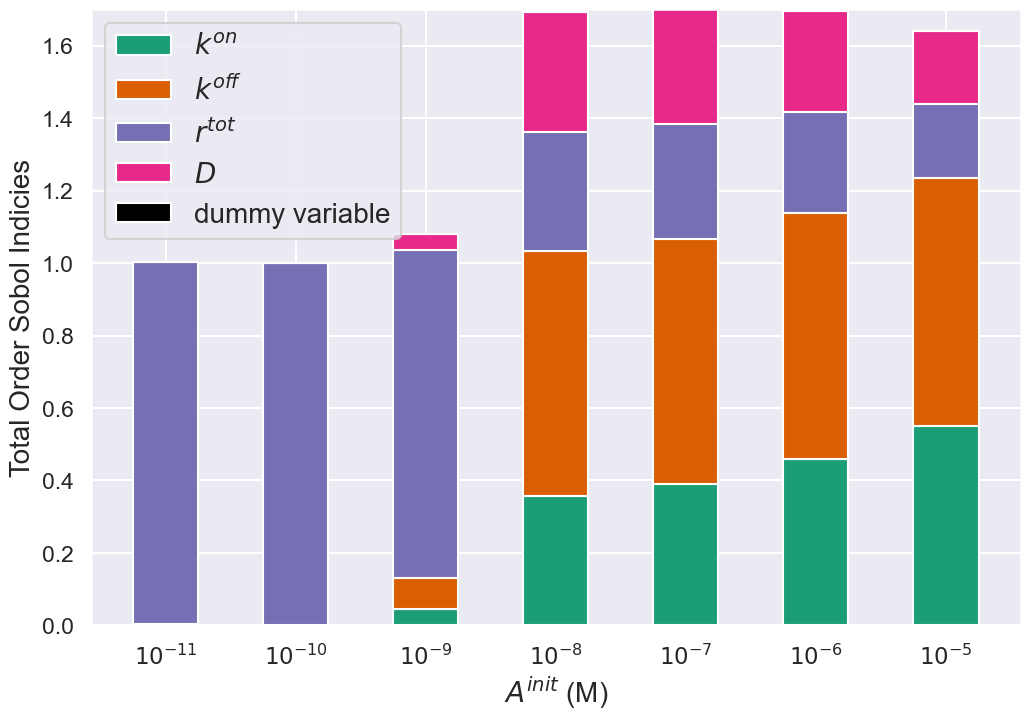

In [15]:

kon_si = np.zeros(len(A0s))
koff_si = np.zeros(len(A0s))
D_si = np.zeros(len(A0s))
rtot_si = np.zeros(len(A0s))
dummy_si = np.zeros(len(A0s))


for i in range(len(indicies_4)):
    vals = indicies_4[i]
    rtot_si[i] = vals[0]
    kon_si[i] = vals[1]
    D_si[i] = vals[2]
    koff_si[i] = vals[3]
    dummy_si[i] = vals[4]

print(len(indicies))
ab_conc = ( r'$10^{-11}$', r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$')


sns.set_theme()
sns.set_context("talk")

width = 0.5
fig, ax = plt.subplots(figsize=(12,8))
bottom = np.zeros(7)

cm = plt.cm.get_cmap('Dark2')
ax.bar(ab_conc, kon_si, width, label=r'$k^{on}$', bottom= bottom, color=cm(0))
bottom+= kon_si
ax.bar(ab_conc, koff_si, width, label=r'$k^{off}$', bottom= bottom, color=cm(1))
bottom+= koff_si
ax.bar(ab_conc, rtot_si, width, label=r'$r^{tot}$', bottom= bottom, color=cm(2))
bottom+= rtot_si
ax.bar(ab_conc, D_si, width, label=r'$D$', bottom= bottom, color=cm(3))
bottom+= D_si
ax.bar(ab_conc, dummy_si, width, label='dummy variable', bottom=bottom, color='black')
ax.legend(loc='best', fontsize=20)
ax.set_xlabel(r'$A^{init}$' + ' (M)', fontsize=20)
ax.set_ylabel('Total Order Sobol Indicies', fontsize=20)
plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/model_s_receptor_occupancytotal_order_sensiv_analysis.png')

7


/var/folders/fj/3c6fc0c93lg7p91tnylb8zj80000gn/T/ipykernel_661/4230593803.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('Dark2')


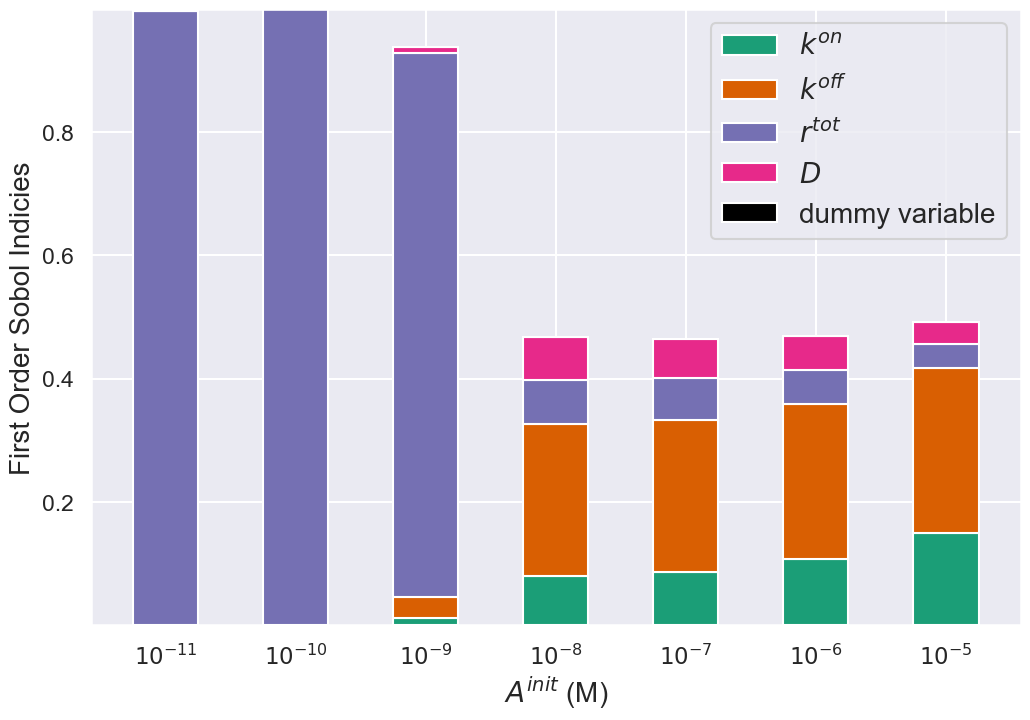

In [16]:

kon_si = np.zeros(len(A0s))
koff_si = np.zeros(len(A0s))
D_si = np.zeros(len(A0s))
rtot_si = np.zeros(len(A0s))
dummy_si = np.zeros(len(A0s))


for i in range(len(indicies_5)):
    vals = indicies_5[i]
    rtot_si[i] = vals[0]
    kon_si[i] = vals[1]
    D_si[i] = vals[2]
    koff_si[i] = vals[3]
    dummy_si[i] = vals[4]

print(len(indicies))
ab_conc = ( r'$10^{-11}$', r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$')


sns.set_theme()
sns.set_context("talk")

width = 0.5
fig, ax = plt.subplots(figsize=(12,8))
bottom = np.zeros(7)

cm = plt.cm.get_cmap('Dark2')
ax.bar(ab_conc, kon_si, width, label=r'$k^{on}$', bottom= bottom, color=cm(0))
bottom+= kon_si
ax.bar(ab_conc, koff_si, width, label=r'$k^{off}$', bottom= bottom, color=cm(1))
bottom+= koff_si
ax.bar(ab_conc, rtot_si, width, label=r'$r^{tot}$', bottom= bottom, color=cm(2))
bottom+= rtot_si
ax.bar(ab_conc, D_si, width, label=r'$D$', bottom= bottom, color=cm(3))
bottom+= D_si
ax.bar(ab_conc, dummy_si, width, label='dummy variable', bottom=bottom, color='black')
ax.legend(loc='best', fontsize=20)
ax.set_xlabel(r'$A^{init}$' + ' (M)', fontsize=20)
ax.set_ylabel('First Order Sobol Indicies', fontsize=20)
plt.savefig('/Users/lukeheirene/ADCC-Project/Figures/model_s_receptor_occupancy_first_order_sensiv_analysis.png')